In [ ]:
import importlib
import subprocess
import sys
import gc

def check_and_install_package(package_name, version=None):
    try:
        importlib.import_module(package_name)
        print(f"\n{package_name} is already installed.")
    except ImportError:
        print(f"\n{package_name} is NOT installed. Installing now...")
        if version:
            subprocess.check_call([sys.executable, "-m", "pip", "install", f"{package_name}=={version}"])
        else:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"{package_name} installation completed.")

# List of packages to check along with specific versions if necessary
packages = [
    {"name": "tqdm", "version": None},
    {"name": "pyspark", "version": "3.5.2"},
    {"name": "gdown", "version": None},
    {"name": "numpy", "version": "1.23.5"}
]

# Checking and installing packages
for package in packages:
    check_and_install_package(package["name"], package["version"])



tqdm is already installed.

pyspark is already installed.

gdown is already installed.

numpy is already installed.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Feature_Engineering") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.executor.memoryOverhead", "12g") \
    .config("spark.executor.cores", "5") \
    .config("spark.kryoserializer.buffer.max", "2047m") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.hadoop.fs.file.impl", "org.apache.hadoop.fs.LocalFileSystem") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:InitiatingHeapOccupancyPercent=35 -XX:ConcGCThreads=4 -XX:ParallelGCThreads=4") \
    .getOrCreate()

# Verifying Spark session creation
print(f"Spark session started with version: {spark.version}")

Spark session started with version: 3.5.3


In [ ]:
# loading the df

!cp '/content/drive/MyDrive/Big Data Analytics - Project/Datasets/Processed_DF.parquet' /content/

output_path = '/content/Processed_DF.parquet'
df = spark.read.parquet(output_path)
print("The Processed DataFrame has been loaded successfully.")


The Processed DataFrame has been loaded successfully.


In [ ]:
df = df.repartition(100)

In [ ]:
df=df.drop('description','major_options','mileage')

In [ ]:
# Counting unique values in 'exterior_color' and 'interior_color' columns
exterior_colors_count = df.select('exterior_color').distinct().count()
interior_colors_count = df.select('interior_color').distinct().count()

print(f"Unique exterior colors: {exterior_colors_count}")
print(f"Unique interior colors: {interior_colors_count}")

Unique exterior colors: 23036
Unique interior colors: 38528


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StringType

# Listing top colors for both exterior and interior
colors = ['White', 'Black', 'Gray', 'Silver', 'Red', 'Blue', 'Brown', 'Green', 'Beige', 'Orange', 'Gold', 'Yellow', 'Purple']

# Creating a UDF to find colors in the color columns
@F.udf(returnType=ArrayType(StringType()))
def find_colors(color_string):
    if color_string is None or color_string.strip() == "":
        return ["Other"]  # Handle empty or null values
    found_colors = [c for c in colors if c.lower() in color_string.lower()]
    return found_colors if found_colors else ["Other"]  # Label non-matching colors as "Other"

# Applying the UDF to both the exterior and interior color columns
df = df.withColumn("exterior_color_array", find_colors("exterior_color"))
df = df.withColumn("interior_color_array", find_colors("interior_color"))

# Creating a column with the count of colors found for both exterior and interior
df = df.withColumn("exterior_color_count", F.size("exterior_color_array"))
df = df.withColumn("interior_color_count", F.size("interior_color_array"))

# Joining the color arrays into string columns
df = df.withColumn("exterior_color", F.array_join("exterior_color_array", ", "))
df = df.withColumn("interior_color", F.array_join("interior_color_array", ", "))

# Labeling mixed colors for both exterior and interior colors
df = df.withColumn(
    "exterior_color",
    F.when(F.col("exterior_color_count") > 1, "Mixed Colors")
     .otherwise(F.col("exterior_color")))

df = df.withColumn(
    "interior_color",
    F.when(F.col("interior_color_count") > 1, "Mixed Colors")
     .otherwise(F.col("interior_color")))

# Dropping temporary columns
df = df.drop("exterior_color_array", "exterior_color_count", "interior_color_array", "interior_color_count")


In [ ]:
# Counting the occurrences of each exterior and interior color and calculating percentages
exterior_color_counts = df.groupBy("exterior_color").count().withColumn(
    "percentage", F.round((F.col("count") / df.count()) * 100, 2))

interior_color_counts = df.groupBy("interior_color").count().withColumn(
    "percentage", F.round((F.col("count") / df.count()) * 100, 2))

# Showing the results
print("Exterior Color Distribution:")
exterior_color_counts.orderBy(F.desc("count")).show(truncate=False)

Exterior Color Distribution:
+--------------+------+----------+
|exterior_color|count |percentage|
+--------------+------+----------+
|White         |675979|22.53     |
|Black         |580148|19.34     |
|Other         |543638|18.12     |
|Silver        |384540|12.82     |
|Blue          |253263|8.44      |
|Red           |242331|8.08      |
|Gray          |231172|7.71      |
|Green         |23026 |0.77      |
|Mixed Colors  |19728 |0.66      |
|Brown         |12905 |0.43      |
|Orange        |11638 |0.39      |
|Gold          |10544 |0.35      |
|Beige         |5065  |0.17      |
|Yellow        |4855  |0.16      |
|Purple        |1208  |0.04      |
+--------------+------+----------+



In [ ]:
print("Interior Color Distribution:")
interior_color_counts.orderBy(F.desc("count")).show(truncate=False)

Interior Color Distribution:
+--------------+-------+----------+
|interior_color|count  |percentage|
+--------------+-------+----------+
|Black         |1624033|54.13     |
|Other         |577578 |19.25     |
|Gray          |383966 |12.8      |
|Mixed Colors  |171212 |5.71      |
|White         |91545  |3.05      |
|Brown         |65943  |2.2       |
|Red           |34117  |1.14      |
|Silver        |24124  |0.8       |
|Blue          |22828  |0.76      |
|Green         |2048   |0.07      |
|Gold          |1193   |0.04      |
|Orange        |1133   |0.04      |
|Yellow        |134    |0.0       |
|Purple        |121    |0.0       |
|Beige         |65     |0.0       |
+--------------+-------+----------+



In [ ]:
print(f"Final processed DataFrame used for the model has {df.count()} rows and {len(df.columns)} columns.")

Final processed DataFrame used for the model has 3000040 rows and 39 columns.


In [ ]:
# Calculating the average price
avg_price = df.agg({"price": "avg"}).collect()[0][0]
print(f"Average price of a car: {round(avg_price)}")

Average price of a car: 29933


In [ ]:
import pandas as pd
from IPython.display import display
import pyspark.sql.functions as F

# Converting the Spark DataFrame to a Pandas DataFrame and displaying 3 random rows with all columns
pd.set_option('display.max_columns', None)
pandas_df = df.orderBy(F.rand()).limit(3).toPandas()
display(pandas_df)


,fuel_type,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,engine_type,exterior_color,franchise_dealer,fuel_tank_volume,height,highway_fuel_economy,horsepower,interior_color,is_new,latitude,length,listed_date,listing_color,longitude,make_name,maximum_seating,model_name,price,savings_amount,seller_rating,sp_name,torque,transmission,transmission_display,wheel_system_display,wheelbase,width,year,combined_fuel_economy,legroom,log_mileage,major_options_count
0,Gasoline,SUV / Crossover,Lumberton,26.0,74,28358,2500.0,I4,White,True,14.5,66.3,33.0,170.0,Black,True,34.633400,184.5,2020-06-28,WHITE,-78.993797,Nissan,5.0,Rogue,24520.0,0,3.600000,Nissan of Lumberton,175.0,CVT,Continuously Variable Transmission,Front-Wheel Drive,106.5,72.4,2020,29.5,80.9,1.61,4
1,Gasoline,SUV / Crossover,Humble,31.0,79,77338,1600.0,I4,Silver,True,10.8,62.4,36.0,122.0,Black,True,29.990299,169.1,2020-06-24,SILVER,-95.275597,Nissan,5.0,Kicks,16358.0,0,3.571429,Robbins Nissan,114.0,CVT,Continuously Variable Transmission,Front-Wheel Drive,103.1,69.3,2020,33.5,76.9,1.10,3
2,Gasoline,Pickup Truck,Faribault,15.0,277,55021,5700.0,V8,Silver,True,26.0,77.6,21.0,395.0,Black,True,44.294601,232.9,2019-12-08,SILVER,-93.292999,RAM,5.0,1500,48387.0,0,4.725490,Harry Browns Family Automotive,410.0,A,8-Speed Automatic,Four-Wheel Drive,144.6,82.1,2020,18.0,86.1,3.04,7




---



### **Sample Consistency Check with Column Modification**

I am checking whether two samples, taken with the same seed, yield the same data. After adding 1 to the last column of one sample, I drop the modified column and verify if the remaining data in both samples is identical.

In [ ]:
from pyspark.sql.functions import col

# Sampling the DataFrame twice using the same seed
df_sample_1 = df.sample(fraction=0.1, seed=42)


# Geting the name of the last column in the DataFrame
last_column = df_sample_1.columns[-1]

# Adding 1 to the values in the last column and creating a new column 'X'
df_sample_1 = df_sample_1.withColumn("X", col(last_column) + 1) # Now col is defined and can be used


# Sampling the DataFrame again to creating df_sample_2 (without column 'X')
df_sample_2 = df.sample(fraction=0.1, seed=42)

# Dropping the extra column 'X' from df_sample_1
df_sample_1_without_X = df_sample_1.drop("X")

# Now comparing if df_sample_1_without_X and df_sample_2 are identical
if df_sample_1_without_X.subtract(df_sample_2).count() == 0 and df_sample_2.subtract(df_sample_1_without_X).count() == 0:
    print("The samples are identical (excluding column 'X').")
else:
    print("The samples are different.")

The samples are identical (excluding column 'X').


The result is identical, which confirms that whenever I select the same seed, the same sample dataset is consistently selected. This allows me to confidently track how feature-engineered columns, impact the dataset without altering the underlying sample. This way, I can isolate and analyze the effect of new features on the same base sample.



---



## **DF Visualization**

In [ ]:
#loading the necessary libraries for data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
import pandas as pd
from tqdm import tqdm

batch_size = 100000
df_visual = pd.DataFrame()
total_rows = df.count()

# Initializing the progress bar
with tqdm(total=total_rows) as pbar:

    # Splitting the Spark DataFrame into batches
    for i in range(0, total_rows, batch_size):
        temp_df = df.limit(batch_size).toPandas()
        df_visual = pd.concat([df_visual, temp_df], ignore_index=True)


        # Updating the progress bar
        pbar.update(min(batch_size, total_rows - i))  # Updating by batch_size or remaining rows


100%|██████████| 3000040/3000040 [12:30<00:00, 3995.89it/s]

'df_visual'(pandas df) created from spark df


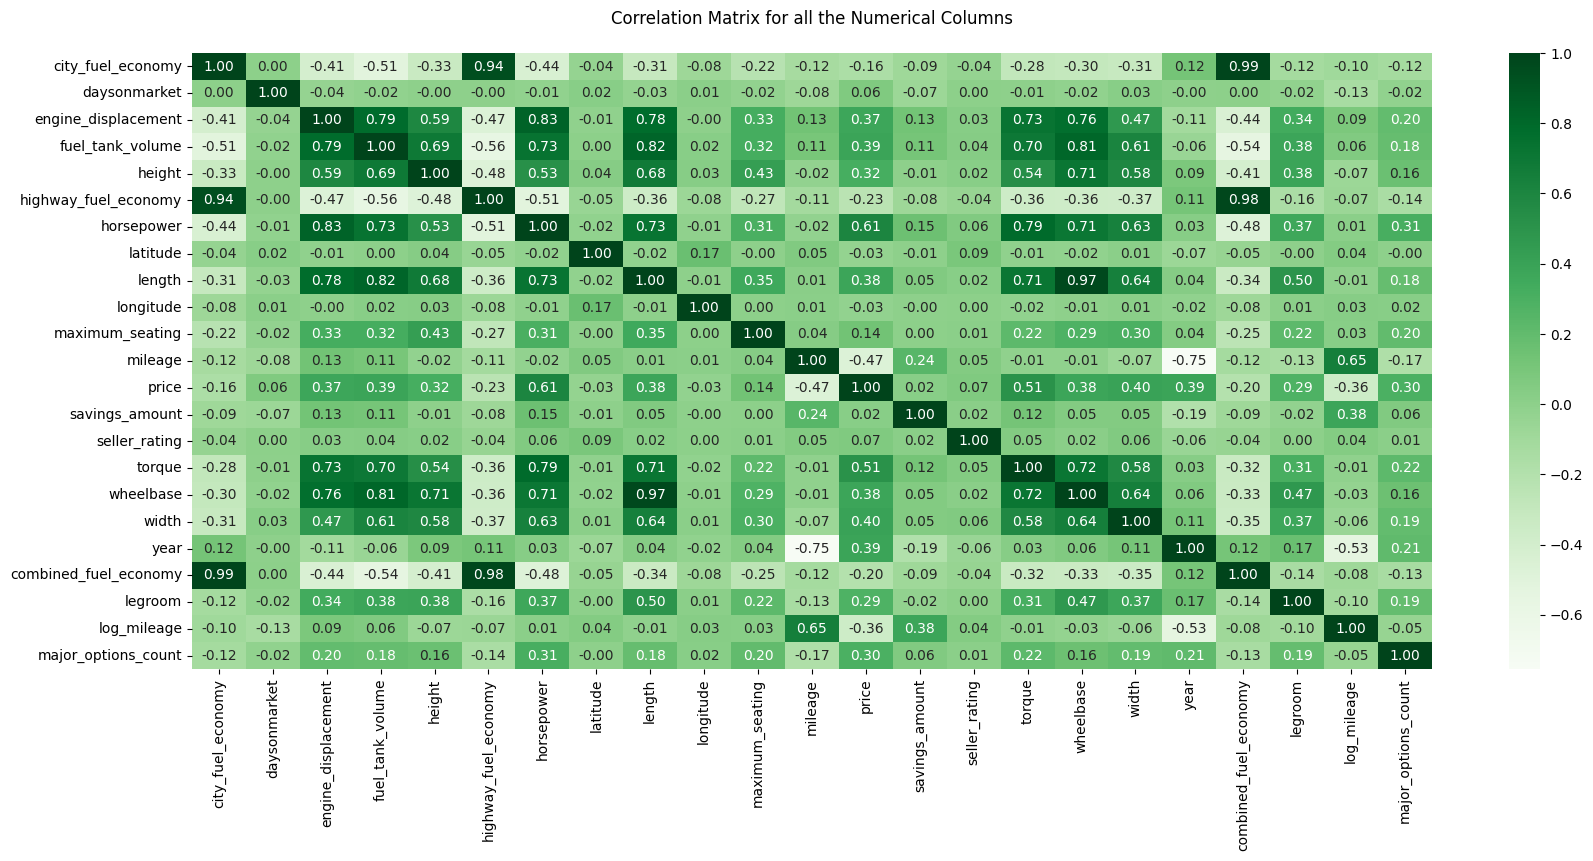

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

# Selecting only the numerical columns from df_visual_sample
df_numerical = df_visual.select_dtypes(include=['number'])

# Computing the correlation matrix for numerical columns
corr = df_numerical.corr()

plt.figure(figsize=(20, 8))
sns.heatmap(corr, cmap="Greens", annot=True, fmt='.2f')
plt.title('Correlation Matrix for all the Numerical Columns\n')
plt.show()


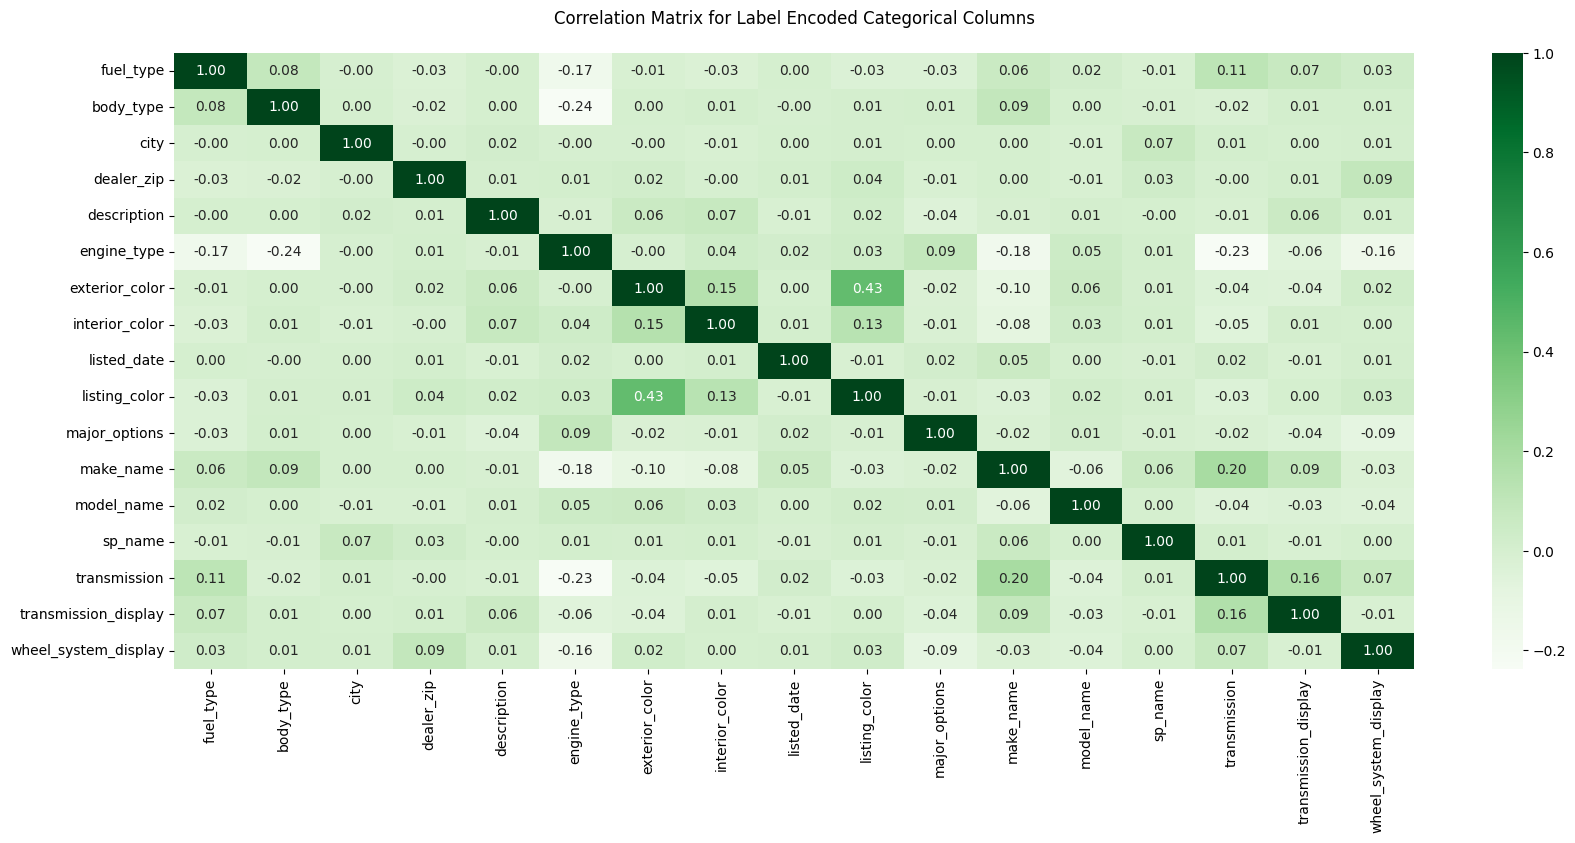

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Selecting only the categorical columns from df_visual
df_categorical = df_visual.select_dtypes(include=['object'])

# Applying Label Encoding to categorical columns
df_encoded = df_categorical.copy()
label_encoder = LabelEncoder()

# Applying label encoding to each categorical column
for col in df_categorical.columns:
    df_encoded[col] = label_encoder.fit_transform(df_categorical[col].astype(str))

# Computing the correlation matrix for label-encoded categorical columns
corr = df_encoded.corr()

# Plotting the heatmap for encoded categorical columns
plt.figure(figsize=(20, 8))
sns.heatmap(corr, cmap="Greens", annot=True, fmt='.2f')
plt.title('Correlation Matrix for Label Encoded Categorical Columns\n')
plt.show()


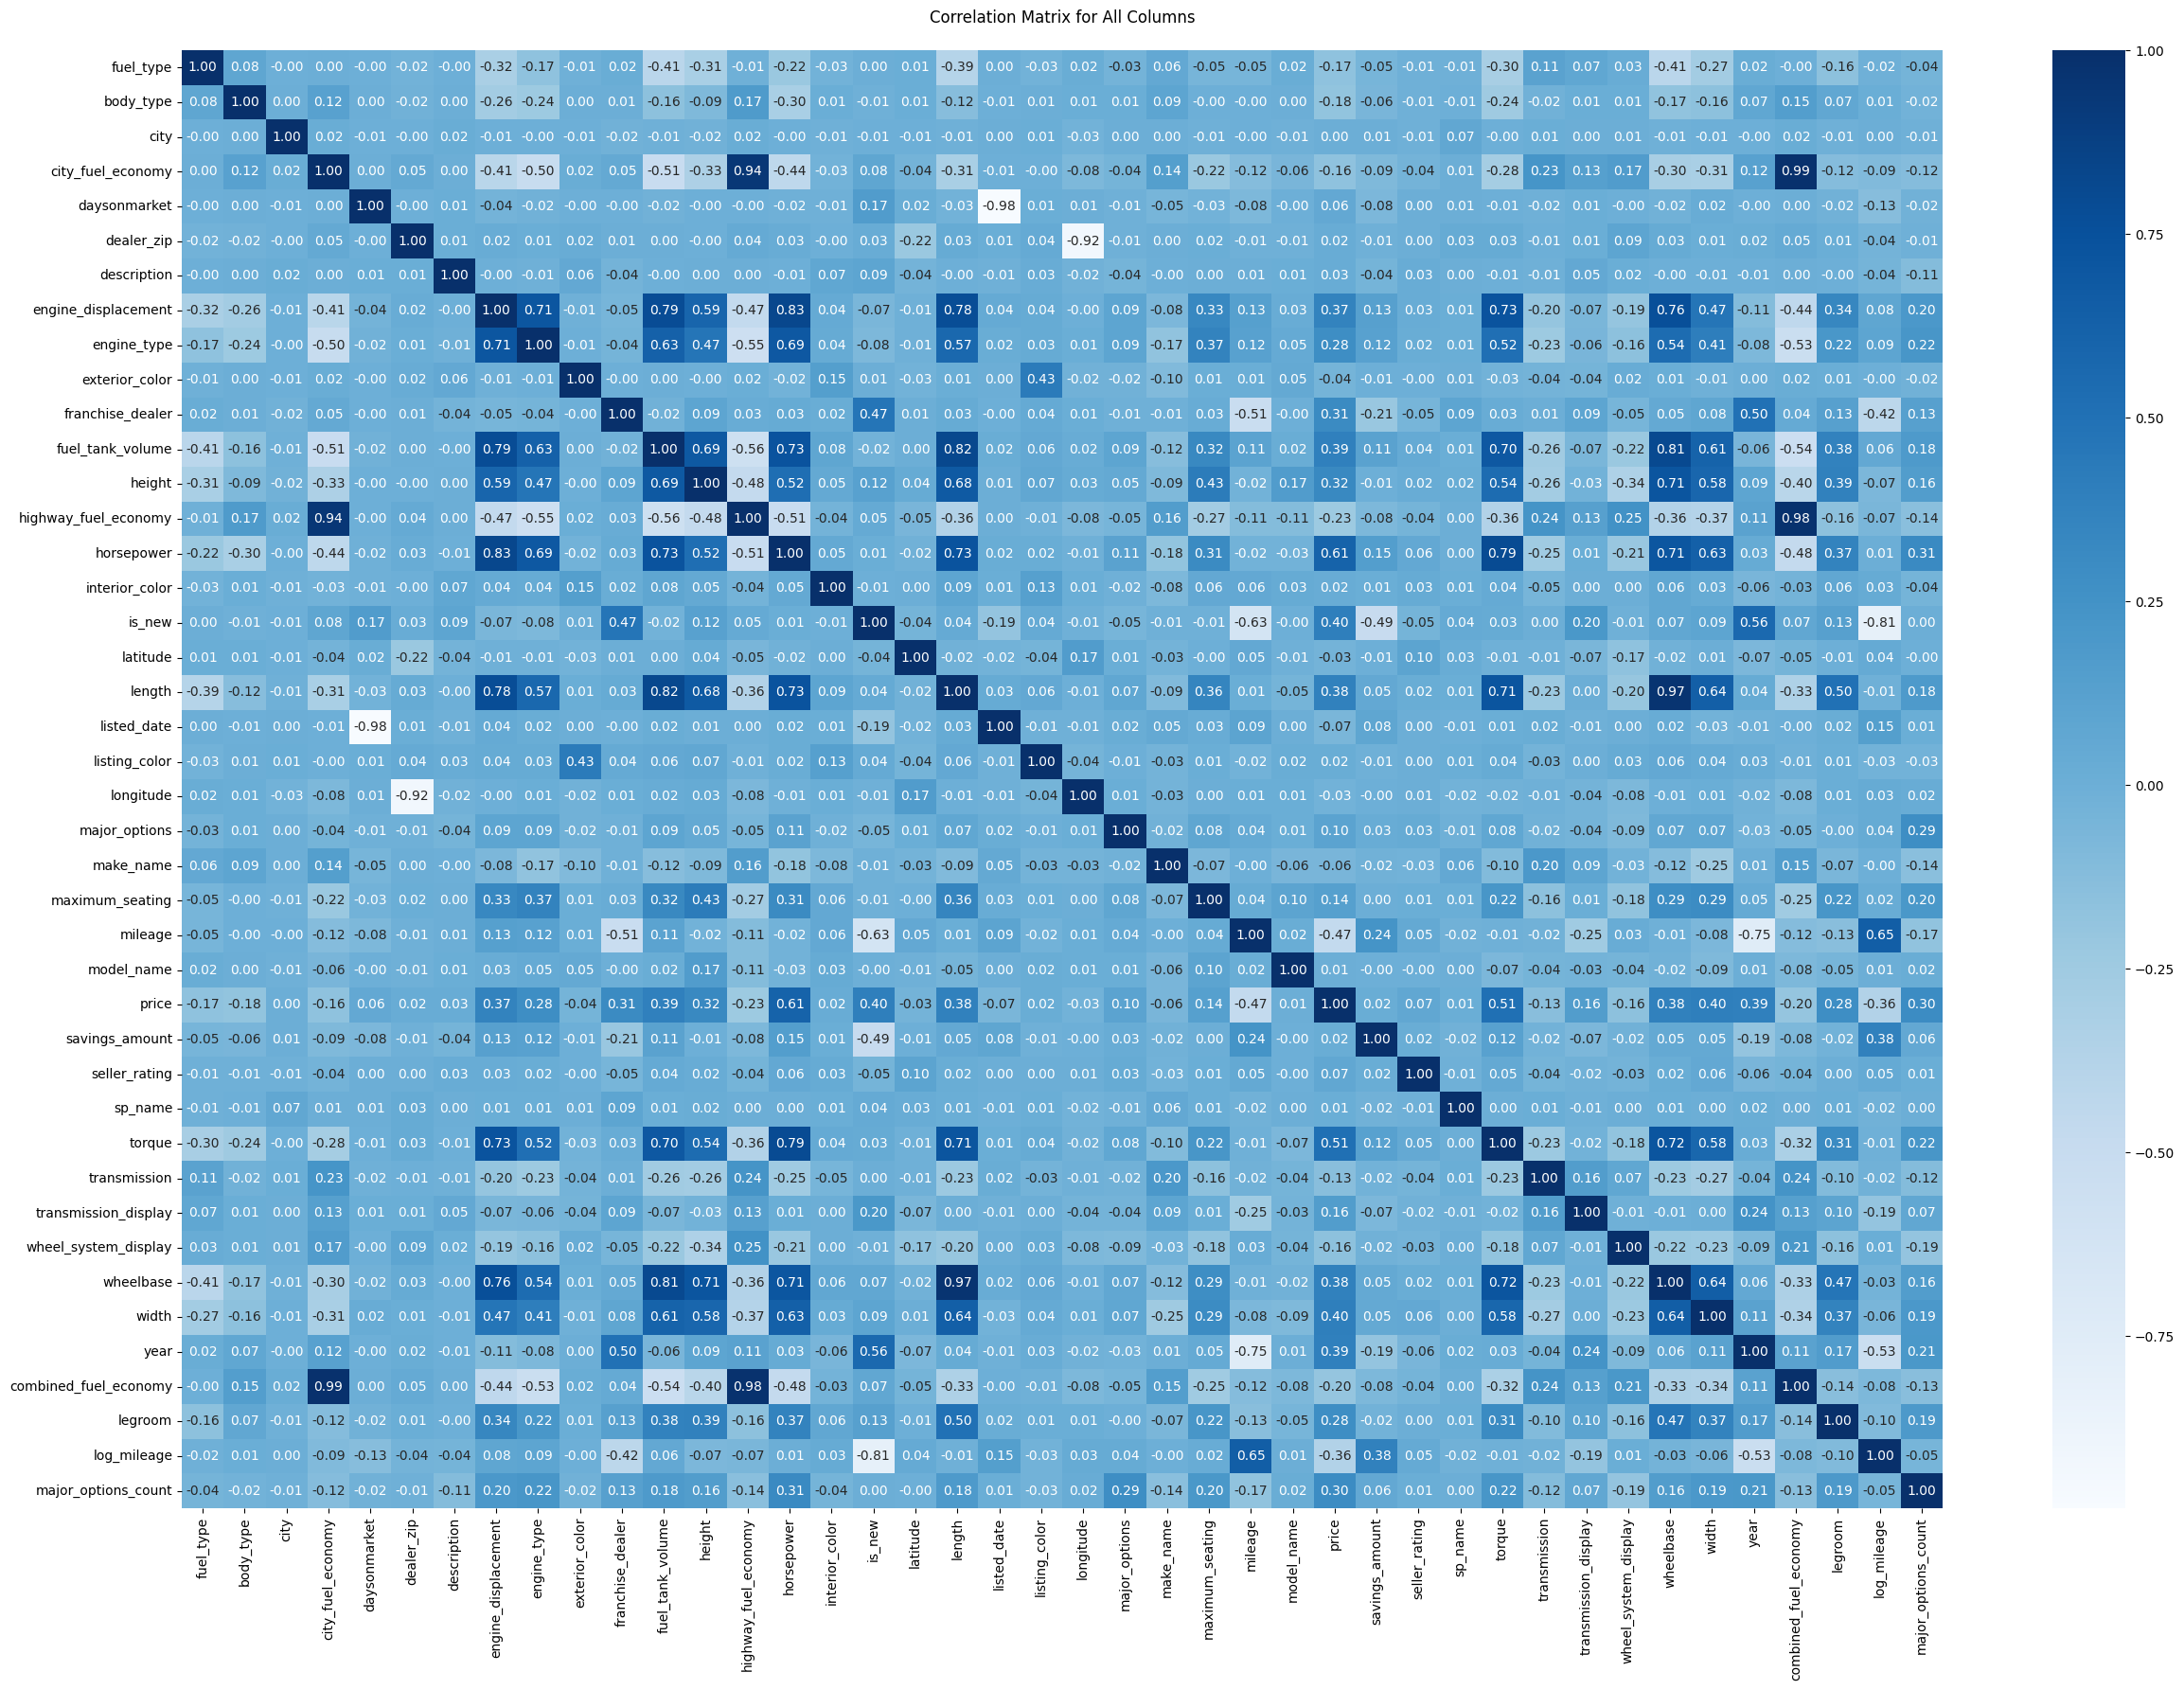

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

# plotting for 1 million records
df_visual_sample = df_visual.sample(n=1000000, random_state=42)
df_visual_sample_encoded = df_visual_sample.copy()

# Selecting categorical columns
categorical_columns = df_visual_sample.select_dtypes(include=['object']).columns

# Applying Label Encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    df_visual_sample_encoded[col] = label_encoder.fit_transform(df_visual_sample[col].astype(str))

# Now df_visual_sample_encoded contains both numerical and encoded categorical columns

# Computing the correlation matrix for all columns
corr = df_visual_sample_encoded.corr()

# Plotting the heatmap for all columns (including encoded categorical columns)
plt.figure(figsize=(30, 20))
sns.heatmap(corr, cmap="Blues", annot=True, fmt='.2f')
plt.title('Correlation Matrix for All Columns\n')
plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Creating a copy to ensure the original data isn't modified
df_visual_encoded = df_visual.copy()

# Selecting categorical columns
categorical_columns = df_visual_sample.select_dtypes(include=['object']).columns

# Applying Label Encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    df_visual_sample_encoded[col] = label_encoder.fit_transform(df_visual_sample[col].astype(str))

# Now df_visual_sample_encoded contains both numerical and encoded categorical columns

# Computing the correlation matrix for all columns
corr = df_visual_sample_encoded.corr()

# Extracting the column pairs with correlation greater than 0.75 or less than -0.75
high_corr_pairs = corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1.0)]

# Unstacking, dropping NaNs, and filtering for absolute correlation > 0.75
high_corr_pairs = high_corr_pairs.unstack().dropna().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs) > 0.75]  # Filter for absolute correlation > 0.75

# Creating a set to store printed pairs to avoid redundancy
seen_pairs = set()

# Groupping the high correlation pairs by their first column and avoid redundant data
print("\nColumn pairs with correlation > 0.75 or < -0.75:\n")

for (col1, col2), corr_value in high_corr_pairs.items():

    # Ensuring each pair is printed only once (ignoring reversed duplicates)
    if (col1, col2) not in seen_pairs and (col2, col1) not in seen_pairs:
        print(f"{col1}:")
        print(f"    {col2:<30} {corr_value: .6f}\n")
        seen_pairs.add((col1, col2))




Column pairs with correlation > 0.75 or < -0.75:

combined_fuel_economy:
    city_fuel_economy               0.986976

highway_fuel_economy:
    combined_fuel_economy           0.983321

wheelbase:
    length                          0.966102

highway_fuel_economy:
    city_fuel_economy               0.941255

horsepower:
    engine_displacement             0.828887

fuel_tank_volume:
    length                          0.815081

fuel_tank_volume:
    wheelbase                       0.811318

horsepower:
    torque                          0.793814

fuel_tank_volume:
    engine_displacement             0.785700

engine_displacement:
    length                          0.779008

engine_displacement:
    wheelbase                       0.759748

year:
    mileage                        -0.751842

is_new:
    log_mileage                    -0.810650

longitude:
    dealer_zip                     -0.920972

listed_date:
    daysonmarket                   -0.984415



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Checking the total number of rows in the DataFrame
total_rows = df_visual.shape[0]

# Printing the total number of rows
print(f"Total rows in df_visual: {total_rows}")
df_visual_sample = df_visual.sample(n=min(5000000, total_rows), random_state=42)

# Creating a copy to ensure the original data isn't modified
df_visual_sample_encoded = df_visual_sample.copy()

# Selecting categorical columns
categorical_columns = df_visual_sample.select_dtypes(include=['object']).columns

# Applying Label Encoding to categorical columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    df_visual_sample_encoded[col] = label_encoder.fit_transform(df_visual_sample[col].astype(str))

# Now df_visual_sample_encoded contains both numerical and encoded categorical columns

# Computing the correlation matrix for all columns
correlation_matrix = df_visual_sample_encoded.corr()

# Setting a correlation threshold
threshold = 0.8

# Creating a dictionary to track the adjacency list (for graph traversal)
adjacency_list = {col: [] for col in correlation_matrix.columns}

# Populating the adjacency list where correlations exceed the threshold
for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
        if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold:
            adjacency_list[col1].append(col2)

# Function to perform DFS and find all connected components (groups)
def dfs(node, visited, group):
    visited.add(node)
    group.append(node)
    for neighbor in adjacency_list[node]:
        if neighbor not in visited:
            dfs(neighbor, visited, group)


# Finding all groups of highly correlated columns
visited = set()
correlated_groups = []

for column in adjacency_list:
    if column not in visited:
        group = []
        dfs(column, visited, group)
        if len(group) > 1:
            correlated_groups.append(group)

# Displaying the groups of highly correlated columns
print("\nGroups of highly correlated columns:")
for group in correlated_groups:
    print(group)


Total rows in df_visual: 3100000

Groups of highly correlated columns:
['city_fuel_economy', 'highway_fuel_economy', 'combined_fuel_economy']
['daysonmarket', 'listed_date']
['dealer_zip', 'longitude']
['engine_displacement', 'horsepower']
['fuel_tank_volume', 'length', 'wheelbase']
['is_new', 'log_mileage']


In [ ]:
import pandas as pd

# SelectAssuming only numerical columns for correlation calculation
df_numerical = df_visual.select_dtypes(include=['number'])

# Computing the correlation matrix
correlation_matrix = df_numerical.corr()

# Getting the correlation score between 'engine_displacement' and 'horsepower'
correlation_score= correlation_matrix.loc['engine_displacement', 'horsepower']
print('Correlation between [engine_displacement, horsepower] is:',round(correlation_score,2))


Correlation between [engine_displacement, horsepower] is: 0.83


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Creating a copy of the DataFrame
df_combined = df_visual[['fuel_type', 'combined_fuel_economy']].copy()

# Encoding the 'fuel_type' column using LabelEncoder
label_encoder = LabelEncoder()
df_combined['fuel_type_encoded'] = label_encoder.fit_transform(df_combined['fuel_type'])

# Calculating and printing the correlation between the encoded 'fuel_type' and 'combined_fuel_economy'
correlation_score = df_combined[['fuel_type_encoded', 'combined_fuel_economy']].corr().iloc[0, 1]
print(f"Correlation between fuel_type and combined_fuel_economy: {correlation_score:.2f}")

del df_combined

Correlation between fuel_type and combined_fuel_economy: -0.00




---



## **Interaction Features**

#### **Creating Interaction Terms for Horsepower, Engine Displacement, and Torque**

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, DenseVector

# Assembling the features into a vector column for standardization
assembler = VectorAssembler(inputCols=['horsepower', 'engine_displacement', 'torque'], outputCol='features')

# Standardizing the columns
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withMean=True, withStd=True)

# Creating a pipeline to apply the assembler and scaler
pipeline = Pipeline(stages=[assembler, scaler])

# Fitting the pipeline and transforming the original DataFrame df
df = pipeline.fit(df).transform(df)

# Defining a UDF to extract each value from the DenseVector returned by the scaler
def extract_element(v, idx):
    return float(v[idx])

extract_element_udf = F.udf(extract_element)

# Extracting individual columns for the scaled features and add them directly to df
df = df.withColumn('scaled_horsepower', extract_element_udf(F.col('scaled_features'), F.lit(0))) \
       .withColumn('scaled_engine_displacement', extract_element_udf(F.col('scaled_features'), F.lit(1))) \
       .withColumn('scaled_torque', extract_element_udf(F.col('scaled_features'), F.lit(2)))

# Creating interaction terms and rounding them
df = df.withColumn('hp_x_engine_disp', F.round(F.col('scaled_horsepower') * F.col('scaled_engine_displacement'), 2)) \
       .withColumn('hp_x_torque', F.round(F.col('scaled_horsepower') * F.col('scaled_torque'), 5))

# Showing the resulting DataFrame with interaction terms added
df.select('horsepower', 'engine_displacement', 'torque', 'hp_x_engine_disp', 'hp_x_torque').show()


+----------+-------------------+------+----------------+-----------+
|horsepower|engine_displacement|torque|hp_x_engine_disp|hp_x_torque|
+----------+-------------------+------+----------------+-----------+
|     276.0|             3600.0|265.22|            0.16|        0.0|
|     276.0|             3600.0|265.22|            0.16|        0.0|
|     276.0|             3600.0|265.22|            0.16|        0.0|
|     241.0|             2000.0| 273.0|            0.05|   -0.00537|
|     241.0|             2000.0| 273.0|            0.05|   -0.00537|
|     241.0|             2000.0| 273.0|            0.05|   -0.00537|
|     440.0|             2900.0| 405.0|           -0.07|    2.81393|
|     292.0|             3600.0| 260.0|            0.25|   -0.02425|
|     292.0|             3600.0| 260.0|            0.25|   -0.02425|
|     292.0|             3600.0| 260.0|            0.25|   -0.02425|
|     130.0|             1600.0| 118.0|            1.37|    1.81131|
|     182.0|             2500.0|26

In [ ]:
df=df.drop('features','scaled_features','scaled_horsepower','scaled_engine_displacement','scaled_torque')

In [ ]:
# Renaming the column year
df = df.withColumnRenamed("year", "manufactured_year")

In [ ]:
# Renaming the column daysonmarket
df = df.withColumnRenamed("daysonmarket", "days_in_market")

In [ ]:
from pyspark.sql import functions as F

# Converting the 'listed_date' column from string to date format
df = df.withColumn('listed_date', F.to_date(F.col('listed_date'), 'yyyy-MM-dd'))

# Extracting the day, month, and year from the 'listed_date'
df = df.withColumn('listed_day', F.dayofmonth(F.col('listed_date')).cast('int')) \
       .withColumn('listed_month', F.month(F.col('listed_date')).cast('int')) \
       .withColumn('listed_year', F.year(F.col('listed_date')).cast('int'))

# Showing the resulting DataFrame with newly created columns
df.select('listed_date', 'listed_day', 'listed_month', 'listed_year').show()
df=df.drop('listed_date')


+-----------+----------+------------+-----------+
|listed_date|listed_day|listed_month|listed_year|
+-----------+----------+------------+-----------+
| 2020-03-06|         6|           3|       2020|
| 2020-03-06|         6|           3|       2020|
| 2020-08-09|         9|           8|       2020|
| 2020-08-09|         9|           8|       2020|
| 2020-08-09|         9|           8|       2020|
| 2020-08-09|         9|           8|       2020|
| 2020-08-09|         9|           8|       2020|
| 2020-08-09|         9|           8|       2020|
| 2020-08-09|         9|           8|       2020|
| 2020-08-09|         9|           8|       2020|
| 2020-09-10|        10|           9|       2020|
| 2020-09-10|        10|           9|       2020|
| 2020-09-10|        10|           9|       2020|
| 2020-09-10|        10|           9|       2020|
| 2020-09-10|        10|           9|       2020|
| 2020-09-10|        10|           9|       2020|
| 2020-09-10|        10|           9|       2020|


In [ ]:
from pyspark.sql import functions as F

# Calculating vehicle age by subtracting manufactured year from listed year
df = df.withColumn('age', F.col('listed_year') - F.col('manufactured_year'))

# Show the updated DataFrame with the new 'age' column
df.select('manufactured_year', 'listed_year', 'age').show()


+-----------------+-----------+---+
|manufactured_year|listed_year|age|
+-----------------+-----------+---+
|             2017|       2020|  3|
|             2017|       2020|  3|
|             2018|       2020|  2|
|             2018|       2020|  2|
|             2011|       2019|  8|
|             2020|       2019| -1|
|             2020|       2020|  0|
|             2020|       2020|  0|
|             2020|       2020|  0|
|             2020|       2020|  0|
|             2020|       2020|  0|
|             2020|       2020|  0|
|             2020|       2020|  0|
|             2020|       2020|  0|
|             2020|       2020|  0|
|             2020|       2020|  0|
|             2020|       2020|  0|
|             2017|       2020|  3|
|             2017|       2020|  3|
|             2019|       2020|  1|
+-----------------+-----------+---+
only showing top 20 rows



In [ ]:
# Counting the number of rows where the manufactured year is greater than the listed year
count_invalid_years = df.filter(F.col('manufactured_year') > F.col('listed_year')).select('manufactured_year', 'listed_year', 'age').count()

# Printing statement with a clear explanation
print(f"Number of rows where the manufactured year is greater than the listed year: {count_invalid_years}")


Number of rows where the manufactured year is greater than the listed year: 307556


In [ ]:
# Replacing 'manufactured_year' with 'listed_year' when manufactured_year is greater than listed_year
df = df.withColumn('manufactured_year',
                   F.when(F.col('manufactured_year') > F.col('listed_year'), F.col('listed_year'))
                    .otherwise(F.col('manufactured_year')))

# Recalculating the age after the replacement
df = df.withColumn('age', F.col('listed_year') - F.col('manufactured_year'))

# Counting the number of rows where the manufactured year is greater than the listed year after the replacement
count_invalid_years = df.filter(F.col('manufactured_year') > F.col('listed_year')).count()

print(f"After handling the abnormalities (replacing manufactured_year with listed_year where needed),\n"
      f"the number of rows where the manufactured year is greater than the listed year is: {count_invalid_years}")


After handling the abnormalities (replacing manufactured_year with listed_year where needed),
the number of rows where the manufactured year is greater than the listed year is: 0


In [ ]:
from pyspark.sql import functions as F

# Counting occurrences of each 'age' value
age_count_df = df.groupBy('age').agg(F.count('age').alias('count'))

# Calculating total count of rows
total_count = df.count()

# Calculating percentage for each 'age' value and round to 2 decimal places
age_percentage_df = age_count_df.withColumn('percentage', F.round((F.col('count') / total_count) * 100, 2))

# Filtering to show only non-zero percentages
age_percentage_df = age_percentage_df.filter(F.col('percentage') > 0)

# Ordering by age and show the results as a table
age_percentage_df = age_percentage_df.orderBy(F.col('age'))

# Converting to Pandas for easier display
age_percentage_pd = age_percentage_df.toPandas()

# Displaying the top 10 rows of the Pandas DataFrame
print("Top 10 Rows of Age Count and Percentage Table:")
print(age_percentage_pd.head(10))


Top 10 Rows of Age Count and Percentage Table:
   age    count  percentage
0    0  1561489       52.05
1    1   258649        8.62
2    2   208832        6.96
3    3   348037       11.60
4    4   119829        3.99
5    5    91756        3.06
6    6    76035        2.53
7    7    67393        2.25
8    8    52225        1.74
9    9    42958        1.43




---



## **Feature Engineering new coloumns**



# **resale_value_score**

The `resale_value_score` function calculates the overall resale value of a vehicle by summing individual scores based on key factors that influence the vehicle's resale value. These factors include mileage, age, days on the market, and the brand (make) of the vehicle.

### Columns and Factors considered in `resale_value_score`:

- **log_mileage (Mileage Score)**: The vehicle's mileage is an important determinant of resale value. Lower mileage generally indicates less wear and tear, leading to a higher resale value. The mileage score is calculated based on percentile thresholds, with lower mileage receiving higher scores.
  
- **age (Age Score)**: The vehicle's age directly affects its resale value. Newer vehicles generally have a higher resale value, while older vehicles see depreciation over time. The age score reflects this trend, with newer cars receiving the highest scores.

- **days_in_market (Days on Market Score)**: The number of days a vehicle has been on the market is used as an indicator of demand. Vehicles that sell quickly tend to have higher resale value, indicating higher demand. The fewer days a car is on the market, the higher its resale score.

- **make_name (Make Name Score)**: The brand of the vehicle significantly impacts resale value. Ultra-luxury and luxury brands (e.g., Rolls-Royce, BMW, Mercedes) typically hold their value better than mid-range or budget brands. Each brand category is assigned a score based on its position in the market.

### Final Calculation of `resale_value_score`:
The `resale_value_score` is computed by summing the individual scores for mileage, age, days on market, and make name. This gives an overall indication of how well a vehicle is expected to retain its value based on these key factors.



In [ ]:
import pandas as pd
from IPython.display import display
import pyspark.sql.functions as F

# Converting the Spark DataFrame to a Pandas DataFrame and displaying 3 random rows with all columns
pd.set_option('display.max_columns', None)
pandas_df = df.orderBy(F.rand()).limit(3).toPandas()
display(pandas_df)


,fuel_type,body_type,city,city_fuel_economy,days_in_market,dealer_zip,engine_displacement,engine_type,exterior_color,franchise_dealer,fuel_tank_volume,height,highway_fuel_economy,horsepower,interior_color,is_new,latitude,length,listing_color,longitude,make_name,maximum_seating,model_name,price,savings_amount,seller_rating,sp_name,torque,transmission,transmission_display,wheel_system_display,wheelbase,width,manufactured_year,combined_fuel_economy,legroom,log_mileage,major_options_count,hp_x_engine_disp,hp_x_torque,listed_day,listed_month,listed_year,age
0,Gasoline,Pickup Truck,Omaha,22.690001,6,68118,2500.0,Gasoline engine,Black,True,18.09,65.87,29.469999,241.0,Other,True,41.263599,189.8,BLACK,-96.093903,Nissan,5.0,Frontier,33745.0,0,4.200000,Nissan of Omaha,265.22,A,9-Speed Automatic,Unknown,111.0,77.2,2020,26.08,80.16,2.40,0,0.03,0.00000,4,9,2020,0
1,Gasoline,Coupe,Dallas,22.000000,17,75237,2000.0,I4,Red,True,19.00,53.10,31.000000,275.0,Black,False,32.647202,188.3,RED,-96.862000,Chevrolet,4.0,Camaro,23995.0,13,3.363636,Freeman Honda,284.00,A,8-Speed Automatic,Rear-Wheel Drive,110.7,74.7,2019,26.50,73.80,10.38,4,-0.22,0.05385,25,8,2020,1
2,Flex Fuel Vehicle,SUV / Crossover,Vero Beach,22.690001,28,32960,5300.0,V8,Black,True,26.00,74.40,29.469999,355.0,Other,False,27.620199,204.0,BLACK,-80.388901,Chevrolet,7.0,Tahoe,33583.0,1610,4.166667,Dyer Chevrolet,383.00,A,6-Speed Automatic Overdrive,4X2,116.0,80.5,2016,26.08,84.30,11.44,15,2.19,1.32358,13,8,2020,4


In [ ]:
from pyspark.sql import functions as F

# Defining numerical columns
numerical_columns = ['log_mileage', 'age', 'days_in_market']

# Mean calculation
mean_values = df.select([F.mean(F.col(c)).alias(f'mean_{c}') for c in numerical_columns])

# Median calculation (approximation using percentile_approx)
median_values = df.select([F.expr(f'percentile_approx({c}, 0.5)').alias(f'median_{c}') for c in numerical_columns])

# Mode calculation (for Spark, I calculate mode by grouping and ordering by frequency)
mode_values = df.groupBy('log_mileage').count().orderBy(F.desc('count')).select('log_mileage').first()
mode_values_age = df.groupBy('age').count().orderBy(F.desc('count')).select('age').first()
mode_values_days_in_market = df.groupBy('days_in_market').count().orderBy(F.desc('count')).select('days_in_market').first()

# Percentile calculations for each numerical column
percentiles = [0.1, 0.25, 0.75, 0.9]
percentile_exprs = [F.expr(f'percentile_approx({c}, {p})').alias(f'percentile_{int(p*100)}_{c}') for p in percentiles for c in numerical_columns]
percentile_values = df.select(percentile_exprs)

# Converting mean, median, and percentile values to pandas DataFrames
mean_values_pd = mean_values.toPandas()
median_values_pd = median_values.toPandas()
percentile_values_pd = percentile_values.toPandas()

# Displaying the DataFrames
print("Mean Values:")
display(mean_values_pd)

print("\nMedian Values:")
display(median_values_pd)

print("\nMode Values:")
print(f"Mode of log_mileage: {mode_values['log_mileage']}")
print(f"Mode of age: {mode_values_age['age']}")
print(f"Mode of days_in_market: {mode_values_days_in_market['days_in_market']}")


print("\n\nPercentile Values:")
display(percentile_values_pd)


Mean Values:


,mean_log_mileage,mean_age,mean_days_in_market
0,7.339374,2.297415,76.059729



Median Values:


,median_log_mileage,median_age,median_days_in_market
0,8.91,0,35



Mode Values:
Mode of log_mileage: 8.91
Mode of age: 0
Mode of days_in_market: 8


Percentile Values:


,percentile_10_log_mileage,percentile_10_age,percentile_10_days_in_market,percentile_25_log_mileage,percentile_25_age,percentile_25_days_in_market,percentile_75_log_mileage,percentile_75_age,percentile_75_days_in_market,percentile_90_log_mileage,percentile_90_age,percentile_90_days_in_market
0,1.61,0,6,2.3,0,14,10.63,3,82,11.47,7,215


In [ ]:
from pyspark.sql import functions as F

# Creating a new column 'days_in_market_bracket' based on the defined brackets
df = df.withColumn('days_in_market_bracket',
                   F.when(F.col('days_in_market') < 14, 'Very high demand (< 14 days)')
                    .when(F.col('days_in_market') < 35, 'High demand (14-35 days)')
                    .when(F.col('days_in_market') < 82, 'Average demand (35-82 days)')
                    .when(F.col('days_in_market') < 215, 'Low demand (82-215 days)')
                    .otherwise('Very low demand (> 215 days)'))

# Grouping by the 'days_in_market_bracket' and calculate the count for each bracket
days_in_market_distribution = df.groupBy('days_in_market_bracket').agg(F.count('*').alias('count'))

# Calculating total count of rows
total_count = df.count()

# Calculating percentage for each bracket
days_in_market_distribution = days_in_market_distribution.withColumn('percentage',
                               (F.col('count') / total_count) * 100)

# Ordering by percentage
days_in_market_distribution = days_in_market_distribution.orderBy(F.desc('percentage'))

# Showing the resulting df
days_in_market_distribution.show(truncate=False)


+----------------------------+------+------------------+
|days_in_market_bracket      |count |percentage        |
+----------------------------+------+------------------+
|Average demand (35-82 days) |778655|25.95482060239197 |
|High demand (14-35 days)    |767906|25.596525379661607|
|Very high demand (< 14 days)|697507|23.24992333435554 |
|Low demand (82-215 days)    |454957|15.165031132918227|
|Very low demand (> 215 days)|301015|10.033699550672658|
+----------------------------+------+------------------+



In [ ]:
from pyspark.sql import functions as F

# Calculating basic statistics (min, max, mean)
basic_stats = df.agg(
    F.min("price").alias("min_price"),
    F.max("price").alias("max_price"),
    F.mean("price").alias("mean_price")
)

# Calculating percentiles (25th, 50th, 75th, 90th, etc.)
percentiles = df.select(
    F.expr("percentile_approx(price, 0.25)").alias("percentile_25"),
    F.expr("percentile_approx(price, 0.50)").alias("percentile_50"),
    F.expr("percentile_approx(price, 0.75)").alias("percentile_75"),
    F.expr("percentile_approx(price, 0.90)").alias("percentile_90")
)

# Showing the basic statistics
print("Price Statistics:")
basic_stats.show()

# Showing the percentile splits
print("Percentile Splits:")
percentiles.show()


Price Statistics:
+---------+---------+------------------+
|min_price|max_price|        mean_price|
+---------+---------+------------------+
|    165.0|3299995.0|29933.366903974595|
+---------+---------+------------------+

Percentile Splits:
+-------------+-------------+-------------+-------------+
|percentile_25|percentile_50|percentile_75|percentile_90|
+-------------+-------------+-------------+-------------+
|      18450.0|      26475.0|      38210.0|      50505.0|
+-------------+-------------+-------------+-------------+



In [ ]:
# Displaying unique brand names from the 'make_name' column
unique_brands = df.select('make_name').distinct().orderBy('make_name')

# Collecting the unique brand names into a Python list
brand_list = unique_brands.collect()

# Collecting the unique brand names into a Python list
brand_list = [row['make_name'] for row in brand_list]

# Printing 10 brand names per row
for i in range(0, len(brand_list), 10):
    print(brand_list[i:i+10])


['AM General', 'AMC', 'Acura', 'Alfa Romeo', 'Allard', 'Ariel', 'Aston Martin', 'Audi', 'Austin', 'Austin-Healey']
['BMW', 'Bentley', 'Bricklin', 'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Clenet', 'Daewoo']
['Datsun', 'DeLorean', 'DeSoto', 'DeTomaso', 'Dodge', 'Eagle', 'Edsel', 'FIAT', 'Ferrari', 'Fisker']
['Ford', 'Franklin', 'Freightliner', 'GMC', 'Genesis', 'Geo', 'Hillman', 'Honda', 'Hudson', 'Humber']
['Hummer', 'Hyundai', 'INFINITI', 'International Harvester', 'Isuzu', 'Jaguar', 'Jeep', 'Jensen', 'Kaiser', 'Karma']
['Kia', 'Koenigsegg', 'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'Lotus', 'MG', 'MINI', 'Maserati']
['Maybach', 'Mazda', 'McLaren', 'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Mobility Ventures', 'Morris', 'Nash', 'Nissan']
['Oldsmobile', 'Opel', 'Packard', 'Pagani', 'Pininfarina', 'Plymouth', 'Pontiac', 'Porsche', 'RAM', 'Rolls-Royce']
['Rover', 'SRT', 'Saab', 'Saleen', 'Saturn', 'Scion', 'Shelby', 'Spyker', 'Studebaker', 'Subaru']
['Sunbeam', 'Su

In [ ]:
from pyspark.sql import functions as F

# Calculating the average price per brand (make_name) and round it to the nearest integer
brand_avg_price_df = df.groupBy("make_name").agg(F.round(F.mean("price"), 0).alias("avg_price"))

# Showing the rounded average price for each brand
brand_avg_price_df.orderBy("make_name").show(truncate=False)


+-------------+---------+
|make_name    |avg_price|
+-------------+---------+
|AM General   |71702.0  |
|AMC          |24013.0  |
|Acura        |33658.0  |
|Alfa Romeo   |39995.0  |
|Allard       |65977.0  |
|Ariel        |52500.0  |
|Aston Martin |172599.0 |
|Audi         |41994.0  |
|Austin       |16495.0  |
|Austin-Healey|52599.0  |
|BMW          |41624.0  |
|Bentley      |119251.0 |
|Bricklin     |19900.0  |
|Bugatti      |1099998.0|
|Buick        |25699.0  |
|Cadillac     |42197.0  |
|Chevrolet    |28696.0  |
|Chrysler     |23715.0  |
|Clenet       |49900.0  |
|Daewoo       |4388.0   |
+-------------+---------+
only showing top 20 rows



In [ ]:
# Assigning each brand to a price tier based on the average price
brand_avg_price_df = brand_avg_price_df.withColumn(
    "price_category",
    F.when(F.col("avg_price") < 18450, "Budget")
    .when((F.col("avg_price") >= 18450) & (F.col("avg_price") < 26475), "Mid-range")
    .when((F.col("avg_price") >= 26475) & (F.col("avg_price") < 38210), "High-end")
    .when((F.col("avg_price") >= 38210) & (F.col("avg_price") <= 50506), "Luxury")
    .otherwise("Ultra-luxury")  # Cars with price above $50,506
)

# Showing the updated price categories for each brand
brand_avg_price_df.select("make_name", "avg_price", "price_category").orderBy("make_name").show(truncate=False)


+-------------+---------+--------------+
|make_name    |avg_price|price_category|
+-------------+---------+--------------+
|AM General   |71702.0  |Ultra-luxury  |
|AMC          |24013.0  |Mid-range     |
|Acura        |33658.0  |High-end      |
|Alfa Romeo   |39995.0  |Luxury        |
|Allard       |65977.0  |Ultra-luxury  |
|Ariel        |52500.0  |Ultra-luxury  |
|Aston Martin |172599.0 |Ultra-luxury  |
|Audi         |41994.0  |Luxury        |
|Austin       |16495.0  |Budget        |
|Austin-Healey|52599.0  |Ultra-luxury  |
|BMW          |41624.0  |Luxury        |
|Bentley      |119251.0 |Ultra-luxury  |
|Bricklin     |19900.0  |Mid-range     |
|Bugatti      |1099998.0|Ultra-luxury  |
|Buick        |25699.0  |Mid-range     |
|Cadillac     |42197.0  |Luxury        |
|Chevrolet    |28696.0  |High-end      |
|Chrysler     |23715.0  |Mid-range     |
|Clenet       |49900.0  |Luxury        |
|Daewoo       |4388.0   |Budget        |
+-------------+---------+--------------+
only showing top

In [ ]:
from pyspark.sql import functions as F

# Assigning each brand to a price tier based on the average price
brand_avg_price_df = brand_avg_price_df.withColumn(
    "price_category",
    F.when(F.col("avg_price") < 18450, "Budget")
    .when((F.col("avg_price") >= 18450) & (F.col("avg_price") < 26475), "Mid-range")
    .when((F.col("avg_price") >= 26475) & (F.col("avg_price") < 38210), "High-end")
    .when((F.col("avg_price") >= 38210) & (F.col("avg_price") <= 50506), "Luxury")
    .otherwise("Ultra-luxury")  # Cars with price above $50,506
)

# Collecting the makes based on price categories
budget_brands = brand_avg_price_df.filter(F.col("price_category") == "Budget").select("make_name").rdd.flatMap(lambda x: x).collect()
mid_range_brands = brand_avg_price_df.filter(F.col("price_category") == "Mid-range").select("make_name").rdd.flatMap(lambda x: x).collect()
high_end_brands = brand_avg_price_df.filter(F.col("price_category") == "High-end").select("make_name").rdd.flatMap(lambda x: x).collect()
luxury_brands = brand_avg_price_df.filter(F.col("price_category") == "Luxury").select("make_name").rdd.flatMap(lambda x: x).collect()
ultra_luxury_brands = brand_avg_price_df.filter(F.col("price_category") == "Ultra-luxury").select("make_name").rdd.flatMap(lambda x: x).collect()

# Printing the lists
print("Budget brands:", budget_brands)
print("\nMid-range brands:", mid_range_brands)
print("\nHigh-end brands:", high_end_brands)
print("\nLuxury brands:", luxury_brands)
print("\nUltra-luxury brands:", ultra_luxury_brands)


Budget brands: ['Oldsmobile', 'Saturn', 'FIAT', 'Scion', 'Saab', 'Isuzu', 'Pontiac', 'Mercury', 'Suzuki', 'smart', 'MG', 'Geo', 'Daewoo', 'DeSoto', 'Opel', 'Eagle', 'Rover', 'Hillman', 'Austin', 'Edsel']

Mid-range brands: ['Volkswagen', 'Mitsubishi', 'Kia', 'Hyundai', 'Honda', 'MINI', 'Chrysler', 'Hummer', 'Buick', 'Toyota', 'Dodge', 'Nissan', 'Mazda', 'Subaru', 'AMC', 'Datsun', 'Triumph', 'Pininfarina', 'Bricklin', 'Nash', 'VPG', 'Franklin', 'Mobility Ventures']

High-end brands: ['Lexus', 'Jeep', 'Chevrolet', 'INFINITI', 'Acura', 'GMC', 'Ford', 'Studebaker', 'Willys', 'International Harvester', 'Morris']

Luxury brands: ['Jaguar', 'RAM', 'Volvo', 'Hudson', 'Audi', 'Cadillac', 'Genesis', 'Alfa Romeo', 'Mercedes-Benz', 'Lincoln', 'BMW', 'Plymouth', 'Freightliner', 'Fisker', 'DeLorean', 'Clenet']

Ultra-luxury brands: ['Maserati', 'Rolls-Royce', 'Lamborghini', 'SRT', 'Land Rover', 'McLaren', 'Tesla', 'Ferrari', 'Porsche', 'AM General', 'Bentley', 'Aston Martin', 'Jensen', 'Packard', 'L

In [ ]:
# Calculating total unique makes across all categories
total_unique_makes = brand_avg_price_df.select("make_name").distinct().count()

# Calculating the number of makes in each category
budget_brands_count = len(budget_brands)
mid_range_brands_count = len(mid_range_brands)
high_end_brands_count = len(high_end_brands)
luxury_brands_count = len(luxury_brands)
ultra_luxury_brands_count = len(ultra_luxury_brands)

# Summing the individual category counts
total_brands_count_from_categories = (
    budget_brands_count
    + mid_range_brands_count
    + high_end_brands_count
    + luxury_brands_count
    + ultra_luxury_brands_count
)

# Printing results to compare
print(f"Total unique car makes: {total_unique_makes}")
print(f"Total from individual categories: {total_brands_count_from_categories}")


Total unique car makes: 100
Total from individual categories: 100


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

# Broadcasting the lists of brand categories for efficient lookup in Spark
ultra_luxury_brands_bc = spark.sparkContext.broadcast(ultra_luxury_brands)
luxury_brands_bc = spark.sparkContext.broadcast(luxury_brands)
high_end_brands_bc = spark.sparkContext.broadcast(high_end_brands)
mid_range_brands_bc = spark.sparkContext.broadcast(mid_range_brands)
budget_brands_bc = spark.sparkContext.broadcast(budget_brands)

# UDF for mileage score related to resale value
def mileage_score_udf(log_mileage):
    if log_mileage < 2.3:                # Very low mileage (below 25th percentile), highest resale value
        return 10
    elif log_mileage < 8.91:             # Moderately low mileage (between 25th percentile and median), good resale value
        return 7
    elif log_mileage < 10.63:            # Moderate mileage (between median and 75th percentile), average resale value
        return 4
    else:                                # High mileage (above 75th percentile), lower resale value
        return 1

# UDF for age score related to resale value
def age_score_udf(age):                  # Very new cars (2 years old or less), highest resale value
    if age <= 2:
        return 10
    elif age <= 5:                       # Relatively new cars (3 to 5 years old), still good resale value
        return 7
    elif age <= 10:                      # Moderately aged cars (6 to 10 years old), average resale value
        return 4
    else:                                # Older cars (more than 10 years old), lower resale value
        return 1

# UDF for days on market score related to resale value (Assumes that vehicles with fewer days on the market have higher demand and higher resale value)
def days_in_market_score_udf(days_in_market):
    if days_in_market < 14:              # Very high demand (quick sale within 2 weeks), highest resale value
        return 10
    elif days_in_market < 35:            # High demand (sold within 1 month), good resale value
        return 7
    elif days_in_market < 82:            # Average demand (sold within 3 months), moderate resale value
        return 5
    elif days_in_market < 215:           # Lower demand (sold within 6-7 months), lower resale value
        return 3
    else:                                # Very low demand (vehicle has been on the market for over 7 months), lowest resale value
        return 1

# UDF for make_name score related to resale value using broadcasted brand lists (Vehicle make (brand) significantly affects resale value based on the brand's market position ).
def make_name_score_udf(make_name):
    if make_name in ultra_luxury_brands_bc.value:  # Ultra-luxury brands (e.g., Rolls-Royce, Bentley), highest resale value
        return 10
    elif make_name in luxury_brands_bc.value:      # Luxury brands (e.g., BMW, Volvo), very high resale value
        return 8
    elif make_name in high_end_brands_bc.value:    # High-end brands (e.g., Jeep, Lexus), high resale value
        return 7
    elif make_name in mid_range_brands_bc.value:   # Mid-range brands (e.g., Toyota, Honda), moderate resale value
        return 5
    elif make_name in budget_brands_bc.value:      # Budget brands (e.g., Suzuki,FIAT), lower resale value
        return 3
    else:                                          # Other brands (unknown or less recognized), lowest resale value
        return 1


# Registering UDFs
mileage_score = F.udf(mileage_score_udf, T.IntegerType())
age_score = F.udf(age_score_udf, T.IntegerType())
days_in_market_score = F.udf(days_in_market_score_udf, T.IntegerType())
make_name_score = F.udf(make_name_score_udf, T.IntegerType())

# Applying the UDFs to create new columns for the scores
df = df.withColumn("mileage_score", mileage_score(F.col("log_mileage"))) \
       .withColumn("age_score", age_score(F.col("age"))) \
       .withColumn("days_in_market_score", days_in_market_score(F.col("days_in_market"))) \
       .withColumn("make_name_score", make_name_score(F.col("make_name")))

# Calculating the overall resale_value_score by summing the individual scores
df = df.withColumn('resale_value_score',
                   F.col('mileage_score') +
                   F.col('age_score') +
                   F.col('days_in_market_score') +
                   F.col('make_name_score'))

# Showing the resulting DataFrame
df.select('make_name', 'log_mileage', 'age', 'days_in_market',
          'mileage_score', 'age_score', 'days_in_market_score', 'make_name_score', 'resale_value_score').show()


+---------+-----------+---+--------------+-------------+---------+--------------------+---------------+------------------+
|make_name|log_mileage|age|days_in_market|mileage_score|age_score|days_in_market_score|make_name_score|resale_value_score|
+---------+-----------+---+--------------+-------------+---------+--------------------+---------------+------------------+
|  Hyundai|      11.74|  9|            25|            1|        4|                   7|              5|                17|
|     Ford|       0.69|  0|            19|           10|       10|                   7|              7|                34|
|     Ford|      11.74| 14|             1|            1|        1|                  10|              7|                19|
| Cadillac|      10.58|  1|            57|            4|       10|                   5|              8|                27|
|Chevrolet|       0.69|  0|           192|           10|       10|                   3|              7|                30|
|     Ford|     

In [ ]:
# Dropping the individual score columns from the DataFrame

# df = df.drop('age_score', 'make_name_score','mileage_score','days_in_market_score','days_in_market_bracket')

df = df.drop('mileage_score','days_in_market_score','days_in_market_bracket')

# **maintenance_cost**


The `maintenance_cost` function calculates the total maintenance cost by summing several factors that influence a vehicle's upkeep. These factors are derived from different columns in the dataset:
### Columns and Factors considered in `maintenance_cost`:
- **make_name (Brand Cost)**: The brand of the vehicle influences the maintenance cost, with luxury brands (e.g., BMW, Mercedes, Audi) typically incurring higher costs due to premium parts and specialized service requirements.
  
- **age (Age Cost)**: The age of the vehicle in years plays a crucial role in maintenance cost. Older vehicles generally require more frequent and expensive repairs compared to newer models.

- **horsepower (Horsepower Cost)**: Vehicles with higher horsepower engines often require more expensive maintenance due to their performance characteristics, making this a significant factor in calculating overall cost.

- **transmission (Transmission Cost)**: The type of transmission (manual, automatic, CVT, etc.) affects maintenance cost, with more complex transmission types (like dual-clutch or CVT) often incurring higher repair or replacement costs.

- **fuel_type (Fuel Type Cost)**: The type of fuel the vehicle uses (e.g., gasoline, diesel, electric) can impact maintenance costs. Diesel and electric vehicles typically require specialized maintenance compared to standard gasoline-powered vehicles.

- **engine_type (Engine Type Cost)**: The complexity of the engine (e.g., V6, V8, electric motor) influences maintenance costs. More complex engines with more cylinders or specialized designs typically have higher maintenance costs.

In summary, the **maintenance_cost** function incorporates multiple factors (brand, age, horsepower, transmission, fuel type, and engine type) to provide a comprehensive estimate of a vehicle's maintenance needs.



In [ ]:
import pandas as pd
from IPython.display import display

# Converting the Spark DataFrame to a Pandas DataFrame and display the first 2 rows with all columns
pd.set_option('display.max_columns', None)
display(df.limit(2).toPandas())

,fuel_type,body_type,city,city_fuel_economy,days_in_market,dealer_zip,engine_displacement,engine_type,exterior_color,franchise_dealer,fuel_tank_volume,height,highway_fuel_economy,horsepower,interior_color,is_new,latitude,length,listing_color,longitude,make_name,maximum_seating,model_name,price,savings_amount,seller_rating,sp_name,torque,transmission,transmission_display,wheel_system_display,wheelbase,width,manufactured_year,combined_fuel_economy,legroom,log_mileage,major_options_count,hp_x_engine_disp,hp_x_torque,listed_day,listed_month,listed_year,age,age_score,make_name_score,resale_value_score
0,Gasoline,SUV / Crossover,Ontario,20.0,23,91761,3500.0,V6,Blue,True,19.500000,70.6,27.0,284.0,Black,True,34.048500,198.5,BLUE,-117.545998,Nissan,7.0,Pathfinder,34090.0,0,4.200000,Empire Nissan,259.00,CVT,Continuously Variable Transmission,Front-Wheel Drive,114.2,77.3,2020,23.5,83.9,1.61,5,0.18,-0.02369,20,8,2020,0,10,5,32
1,Gasoline,Sedan,Elizabeth,22.0,22,07202,2000.0,I4,Black,False,19.799999,57.8,31.0,252.0,Black,False,40.652599,194.2,BLACK,-74.215897,Audi,5.0,A6,25905.0,849,3.485714,Where Luxury Meets,265.22,A,8-Speed Automatic,All-Wheel Drive,114.6,82.1,2017,26.5,78.7,10.30,8,-0.04,0.00000,18,8,2020,3,7,8,26


In [ ]:
# Renaming the column
df = df.withColumnRenamed("make_name_score", "brand_cost")
df = df.withColumnRenamed("age_score", "age_cost")

In [ ]:
from pyspark.sql import functions as F

# Defining numerical columns
numerical_columns = ['horsepower']

# Mean calculation
mean_values = df.select([F.mean(F.col(c)).alias(f'mean_{c}') for c in numerical_columns])

# Median calculation (approximation using percentile_approx)
median_values = df.select([F.expr(f'percentile_approx({c}, 0.5)').alias(f'median_{c}') for c in numerical_columns])

# Mode calculation (for numerical columns engine_displacement and horsepower)
mode_values_horsepower = df.groupBy('horsepower').count().orderBy(F.desc('count')).select('horsepower').first()

# Percentile calculations for each numerical column
percentiles = [0.1, 0.25, 0.75, 0.9]
percentile_exprs = [F.expr(f'percentile_approx({c}, {p})').alias(f'percentile_{int(p*100)}_{c}') for p in percentiles for c in numerical_columns]
percentile_values = df.select(percentile_exprs)

# Converting mean, median, and percentile values to pandas DataFrames
mean_values_pd = mean_values.toPandas()
median_values_pd = median_values.toPandas()
percentile_values_pd = percentile_values.toPandas()

# Displaying the DataFrames
print("Mean Values:")
display(mean_values_pd)

print("\nMedian Values:")
display(median_values_pd)


print("\nMode Values:")
print(f"Mode of horsepower: {mode_values_horsepower['horsepower']}")

print("\n\nPercentile Values:")
display(percentile_values_pd)



Mean Values:


,mean_horsepower
0,247.593728



Median Values:


,median_horsepower
0,241.0



Mode Values:
Mode of horsepower: 241.0


Percentile Values:


,percentile_10_horsepower,percentile_25_horsepower,percentile_75_horsepower,percentile_90_horsepower
0,147.0,176.0,300.0,375.0


In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Defining categorical columns
categorical_columns = ['fuel_type', 'transmission','engine_type']

# Looping through categorical columns and calculating the percentage distribution
for col in categorical_columns:
    total_count = df.count()
    df_percentage = df.groupBy(col).count().withColumn('percentage', (F.col('count') / total_count) * 100)
    df_percentage = df_percentage.orderBy(F.desc('percentage'))
    df_percentage_pd = df_percentage.toPandas()
    print(f"Percentage Distribution for {col}:")
    display(df_percentage_pd)
    print("\n")


Percentage Distribution for fuel_type:


,fuel_type,count,percentage
0,Gasoline,2681160,89.370808
1,Flex Fuel Vehicle,155993,5.199697
2,Hybrid,76012,2.533700
3,Diesel,44452,1.481714
4,Biodiesel,25855,0.861822
5,Electric,16416,0.547193
6,Compressed Natural Gas,146,0.004867
7,Propane,6,0.000200




Percentage Distribution for transmission:


,transmission,count,percentage
0,A,2482530,82.749897
1,CVT,458016,15.266996
2,M,48425,1.614145
3,Dual Clutch,11069,0.368962




Percentage Distribution for engine_type:


,engine_type,count,percentage
0,I4,1507448,50.247597
1,V6,818732,27.290703
2,V8,386953,12.898261
3,Gasoline engine,83335,2.777796
4,H4,65955,2.198471
5,I3,54304,1.810109
6,I6,51776,1.725844
7,Electric Motor,16416,0.547193
8,I5,5446,0.181531
9,H6,4686,0.156198


In [ ]:
# UDF for horsepower cost
def horsepower_cost_udf(horsepower):
    if horsepower <= 147:                    # Low-power vehicles with lower maintenance cost
        return 3
    elif 147 < horsepower <= 176:            # Moderate power, slightly higher maintenance
        return 5
    elif 176 < horsepower <= 241:            # Around median/mean horsepower, average maintenance cost
        return 7
    elif 241 < horsepower <= 300:            # Higher horsepower vehicles, higher maintenance
        return 8
    elif 300 < horsepower <= 375:            # Performance vehicles, significantly higher maintenance
        return 10
    else:                                    # Very high horsepower vehicles, luxury/performance models
        return 12                            # Increased maintenance cost for very high-performance vehicles

# UDF for transmission cost
def transmission_cost_udf(transmission):
    if transmission == 'Manual':                # Manual transmission generally has lower costs
        return 3
    elif transmission == 'Automatic':           # Automatic transmissions are common and medium-cost
        return 5
    elif transmission == 'CVT':                 # CVT transmissions are complex and have medium-high cost
        return 7
    elif transmission == 'Dual Clutch':         # Dual clutch systems are complex and expensive to maintain
        return 10
    else:                                       # Default case for unknown or unaccounted transmission types
        return 5                                # Medium cost as default

# UDF for fuel type cost
def fuel_type_cost_udf(fuel_type):
    if fuel_type == 'Gasoline':                   # Gasoline is common and low-medium maintenance cost
        return 5
    elif fuel_type == 'Diesel':                   # Diesel engines tend to be higher maintenance
        return 7
    elif fuel_type == 'Electric':                 # Electric vehicles tend to have lower overall maintenance, but expensive repairs
        return 3
    elif fuel_type == 'Hybrid':                   # Hybrids have more complex systems
        return 7
    elif fuel_type == 'Flex Fuel Vehicle':        # Flex fuel vehicles have moderately complex systems
        return 6
    elif fuel_type == 'Compressed Natural Gas':   # CNG systems are less common and slightly more complex
        return 8
    elif fuel_type == 'Propane':                  # Propane systems are rare and have high maintenance
        return 9
    else:                                         # Default case for unknown or unaccounted fuel types
        return 5                                  # Medium cost as default


# UDF for engine type cost based on complexity and maintenance
def engine_type_cost_udf(engine_type):
    if engine_type in ['W16', 'W12']:                             # Extremely complex and rare, very high maintenance costs
        return 10
    elif engine_type in ['V12', 'W8']:                            # Very complex, used in high-end performance or luxury vehicles, high maintenance
        return 9
    elif engine_type in ['V10', 'H6']:                            # Highly complex and expensive to maintain, found in performance-oriented vehicles
        return 8
    elif engine_type in ['V8', 'Diesel engine']:                  # More complex, larger engines requiring higher maintenance
        return 7
    elif engine_type in ['V6', 'H4', 'I6', 'I5']:                 # Moderately complex, higher than standard engines but still common
        return 6
    elif engine_type in ['I4', 'I3', 'Gasoline engine']:          # Common engines, moderate maintenance requirements
        return 5
    elif engine_type in ['I2', 'R2']:                             # Simple but uncommon, minimal maintenance
        return 4
    elif engine_type == 'Electric Motor':                         # Fewer moving parts, lower maintenance overall
        return 3
    else:
        return 5                                                  # Default score for any other uncommon or undefined engine types


# Registering UDFs for different cost factors
horsepower_cost = F.udf(horsepower_cost_udf, T.IntegerType())
transmission_cost = F.udf(transmission_cost_udf, T.IntegerType())
fuel_type_cost = F.udf(fuel_type_cost_udf, T.IntegerType())
engine_type_cost = F.udf(engine_type_cost_udf, T.IntegerType())

# Applying UDFs to create new columns for each cost factor
df = df.withColumn("horsepower_cost", horsepower_cost(F.col("horsepower"))) \
       .withColumn("transmission_cost", transmission_cost(F.col("transmission"))) \
       .withColumn("fuel_type_cost", fuel_type_cost(F.col("fuel_type"))) \
       .withColumn("engine_type_cost", engine_type_cost(F.col("engine_type")))


In [ ]:
# Calculating the overall maintenance_cost by summing the individual scores
df = df.withColumn('maintenance_cost',
                   F.col('horsepower_cost') +
                   F.col('transmission_cost') +
                   F.col('fuel_type_cost') +
                   F.col('brand_cost') +
                   F.col('age_cost') +
                   F.col('engine_type_cost'))

# Displaying the original columns and their corresponding calculated columns,
df.select('make_name', 'horsepower', 'transmission', 'fuel_type', 'age', 'brand_cost',
          'horsepower_cost', 'transmission_cost', 'fuel_type_cost', 'age_cost', 'engine_type_cost', 'maintenance_cost').show()


+---------+----------+------------+---------+---+----------+---------------+-----------------+--------------+--------+----------------+----------------+
|make_name|horsepower|transmission|fuel_type|age|brand_cost|horsepower_cost|transmission_cost|fuel_type_cost|age_cost|engine_type_cost|maintenance_cost|
+---------+----------+------------+---------+---+----------+---------------+-----------------+--------------+--------+----------------+----------------+
|   Nissan|     149.0|         CVT| Gasoline|  0|         5|              5|                7|             5|      10|               5|              37|
|    Honda|     158.0|         CVT| Gasoline|  3|         5|              5|                7|             5|       7|               5|              34|
|     Jeep|     172.0|           M| Gasoline|  6|         7|              5|                5|             5|       4|               5|              31|
|Chevrolet|     445.0|           A|Biodiesel|  0|         7|             12|      

In [ ]:
from functools import reduce
from pyspark.sql.functions import col

# Checking for rows with at least one null value in any column
rows_with_null = df.filter(
    reduce(lambda x, y: x | y, (col(c).isNull() for c in df.columns))
).count()

print(f"Number of rows with at least one null value: {rows_with_null}")

Number of rows with at least one null value: 0


In [ ]:
# Columns to drop
columns_to_drop = ['horsepower_cost', 'transmission_cost', 'fuel_type_cost', 'age_cost', 'engine_type_cost']

# Dropping the columns
df = df.drop(*columns_to_drop)



---



### **Luxury Score**

The `luxury_score` function calculates the overall luxury level of a vehicle by summing various factors that reflect the premium features and exclusivity of the vehicle. These factors are derived from different columns in the dataset:

### Columns and Factors considered in `luxury_score`:
- **brand (Brand Cost)**: The vehicle's brand heavily influences its luxury score. High-end and luxury brands such as BMW, Mercedes, and Audi receive higher scores, reflecting the premium materials, design, and market perception associated with these brands.

- **manufacturing_year (Manufacturing Year Score)**: Newer vehicles generally have more advanced technology and features, contributing to a higher luxury score. Vehicles manufactured in recent years (e.g., 2020) are seen as more luxurious compared to older models from the 1990s or earlier.

- **maximum_seating (Seating Score)**: The seating capacity of a vehicle plays a role in its luxury perception. Sports cars or luxury coupes with fewer seats often score the highest, while high-end SUVs with more seating also receive high scores. Common sedans with standard seating tend to have moderate luxury scores.

- **major_options_count (Options Score)**: The number of optional features or packages a vehicle offers significantly impacts its luxury level. Vehicles with more options (e.g., advanced tech features, premium interior packages) are considered more luxurious, while those with fewer options receive lower scores.

- **transmission_display (Transmission Score)**: The type of transmission also reflects a vehicle’s luxury. More advanced transmissions like 8-speed automatics or dual-clutch systems found in high-performance or luxury vehicles score higher, while simpler manual transmissions score lower.

In summary, the **luxury_score** function incorporates key factors such as brand reputation, manufacturing year, seating capacity, available options, and transmission type to provide an estimate of the overall luxury level of a vehicle.

In [ ]:
import pandas as pd
from IPython.display import display

# Converting the Spark DataFrame to a Pandas DataFrame and display the first 2 rows with all columns
pd.set_option('display.max_columns', None)
display(df.limit(2).toPandas())

,fuel_type,body_type,city,city_fuel_economy,days_in_market,dealer_zip,engine_displacement,engine_type,exterior_color,franchise_dealer,fuel_tank_volume,height,highway_fuel_economy,horsepower,interior_color,is_new,latitude,length,listing_color,longitude,make_name,maximum_seating,model_name,price,savings_amount,seller_rating,sp_name,torque,transmission,transmission_display,wheel_system_display,wheelbase,width,manufactured_year,combined_fuel_economy,legroom,log_mileage,major_options_count,hp_x_engine_disp,hp_x_torque,listed_day,listed_month,listed_year,age,brand_cost,resale_value_score,maintenance_cost
0,Gasoline,SUV / Crossover,Ontario,20.0,23,91761,3500.0,V6,Blue,True,19.500000,70.6,27.0,284.0,Black,True,34.048500,198.5,BLUE,-117.545998,Nissan,7.0,Pathfinder,34090.0,0,4.200000,Empire Nissan,259.00,CVT,Continuously Variable Transmission,Front-Wheel Drive,114.2,77.3,2020,23.5,83.9,1.61,5,0.18,-0.02369,20,8,2020,0,5,32,41
1,Gasoline,Sedan,Elizabeth,22.0,22,07202,2000.0,I4,Black,False,19.799999,57.8,31.0,252.0,Black,False,40.652599,194.2,BLACK,-74.215897,Audi,5.0,A6,25905.0,849,3.485714,Where Luxury Meets,265.22,A,8-Speed Automatic,All-Wheel Drive,114.6,82.1,2017,26.5,78.7,10.30,8,-0.04,0.00000,18,8,2020,3,8,26,38


In [ ]:
from pyspark.sql import functions as F

# Finding the minimum and maximum 'manufactured_year'
min_year = df.agg(F.min(F.col('manufactured_year'))).collect()[0][0]
max_year = df.agg(F.max(F.col('manufactured_year'))).collect()[0][0]

print('Max year :', max_year)
print('Min year :', min_year)

# Creating bins for each 10-year interval and calculating the percentage
df_with_bins = df.withColumn(
    'year_bin',
    ((F.col('manufactured_year') - min_year) / 5).cast('int') * 5 + min_year
)

# Grouping by the 10-year interval and count
year_bin_counts = df_with_bins.groupBy('year_bin').agg(
    F.count('*').alias('count')
)

# Calculating the total number of rows
total_count = df.count()

# Calculating the percentage for each 10-year interval
year_bin_counts = year_bin_counts.withColumn(
    'percentage',
    (F.col('count') / total_count) * 100
)

print("\n")
# Sorting the bins by year and show results
year_bin_counts = year_bin_counts.orderBy('year_bin')

# Displaying the results with the representation in brackets
year_bin_counts.select(
    'year_bin',
    'count',
    F.concat(F.format_number(F.col('percentage'), 2), F.lit('%')).alias('percentage')
).show(n=100, truncate=False)


Max year : 2020
Min year : 1915


+--------+-------+----------+
|year_bin|count  |percentage|
+--------+-------+----------+
|1915    |4      |0.00%     |
|1920    |17     |0.00%     |
|1925    |51     |0.00%     |
|1930    |68     |0.00%     |
|1935    |46     |0.00%     |
|1940    |59     |0.00%     |
|1945    |80     |0.00%     |
|1950    |150    |0.00%     |
|1955    |371    |0.01%     |
|1960    |406    |0.01%     |
|1965    |1087   |0.04%     |
|1970    |756    |0.03%     |
|1975    |585    |0.02%     |
|1980    |532    |0.02%     |
|1985    |1073   |0.04%     |
|1990    |1635   |0.05%     |
|1995    |5328   |0.18%     |
|2000    |29127  |0.97%     |
|2005    |102361 |3.41%     |
|2010    |272051 |9.07%     |
|2015    |1185085|39.50%    |
|2020    |1399168|46.64%    |
+--------+-------+----------+



In [ ]:
from pyspark.sql import functions as F

# Calculating the count and percentage representation of maximum_seating values
seating_distribution = df.groupBy("maximum_seating").count()

# Total number of rows in the DataFrame
total_count = df.count()

# Adding percentage representation
seating_distribution = seating_distribution.withColumn("percentage", (F.col("count") / total_count) * 100)

# Showing the result
seating_distribution.show(truncate=False)


+---------------+-------+--------------------+
|maximum_seating|count  |percentage          |
+---------------+-------+--------------------+
|8.0            |200360 |6.67857761896508    |
|7.0            |305330 |10.177530966253784  |
|4.0            |81174  |2.7057639231476913  |
|3.0            |29676  |0.9891868108425221  |
|2.0            |35105  |1.1701510646524713  |
|10.0           |540    |0.017999760003199958|
|6.0            |301485 |10.049366008453221  |
|15.0           |5906   |0.19686404181277584 |
|5.0            |2035127|67.83666217783762   |
|9.0            |3634   |0.12113171824375676 |
|12.0           |1703   |0.056765909787869495|
+---------------+-------+--------------------+



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Bining the major_options_count in groups of 5
df_binned = df.withColumn("major_options_bin", F.floor(F.col("major_options_count") / 5) * 5)

# Defining the window specification
window_spec = Window.partitionBy()

# Grouping by the binned major_options_count and calculate the count and percentage
df_binned_distribution = df_binned.groupBy("major_options_bin") \
    .agg(F.count("major_options_bin").alias("count")) \
    .withColumn("percentage", (F.col("count") / F.sum("count").over(window_spec)) * 100) \
    .orderBy("major_options_bin")

# Showing the distribution with count and percentage
df_binned_distribution.show()

+-----------------+-------+--------------------+
|major_options_bin|  count|          percentage|
+-----------------+-------+--------------------+
|                0|1262591|  42.085805522593034|
|                5|1248416|   41.61331182250903|
|               10| 430939|  14.364441807442569|
|               15|  48469|  1.6156117918427755|
|               20|   7223| 0.24076345648724684|
|               25|   1859| 0.06196584045546059|
|               30|    411|0.013699817335768857|
|               35|     98|0.003266623111691844|
|               40|     16|5.333262223170357E-4|
|               45|     10|3.333288889481474E-4|
|               50|      6|1.999973333688884...|
|               55|      2|6.666577778962947E-5|
+-----------------+-------+--------------------+



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Grouping by the transmission_display and calculate the count and percentage distribution
df_transmission_distribution = df.groupBy("transmission_display") \
    .agg(F.count("transmission_display").alias("count")) \
    .withColumn("percentage", (F.col("count") / F.sum("count").over(Window.partitionBy())) * 100) \
    .orderBy("percentage", ascending=False)

# Showing the result
df_transmission_distribution.show()


+--------------------+-------+-------------------+
|transmission_display|  count|         percentage|
+--------------------+-------+-------------------+
|           Automatic|1319286| 43.975613658484555|
|Continuously Vari...| 454964|  15.16526446314049|
|   6-Speed Automatic| 425544|  14.18461087185504|
|   8-Speed Automatic| 333315| 11.110351861975174|
|   9-Speed Automatic| 146622|  4.887334835535526|
|6-Speed Automatic...|  88050| 2.9349608671884373|
|   7-Speed Automatic|  44200| 1.4733136891508114|
|   5-Speed Automatic|  40504|  1.350115331795576|
|   4-Speed Automatic|  36843| 1.2280836255516594|
|      6-Speed Manual|  21107| 0.7035572859028547|
|              Manual|  16866| 0.5621925040999454|
|8-Speed Automatic...|  12257| 0.4085612191837442|
|5-Speed Automatic...|  11996| 0.3998613351821976|
|   1-Speed Automatic|   8297|0.27656297916027783|
|4-Speed Automatic...|   8033|0.26776309649204677|
|      5-Speed Manual|   7874|0.26246316715777124|
| 6-Speed Dual Clutch|   6190|0

In [ ]:
def manufactured_year_score(manufactured_year):
    if manufactured_year == 2020:    # Newest vehicles
        return 10
    elif manufactured_year >= 2015:  # Recent vehicles
        return 8
    elif manufactured_year >= 2005:  # Moderately aged vehicles
        return 6
    elif manufactured_year >= 1990:  # Older vehicles
        return 4
    else:                            # Very old vehicles
        return 2

# UDF for seating score based on maximum seating capacity and luxury considerations
def seating_score_udf(maximum_seating):
    if maximum_seating == 2.0:                # Sports cars or luxury coupes, highest luxury
        return 10
    elif maximum_seating == 7.0:              # High-end SUVs or premium large vehicles, high luxury
        return 9
    elif maximum_seating in [9.0, 8.0]:       # Higher seating in luxury vehicles, but less common
        return 8
    elif maximum_seating in [10.0, 12.0]:     # Larger vehicles, often SUVs, but lower luxury
        return 6
    elif maximum_seating == 6.0:              # Mid-sized SUVs or crossovers, average luxury
        return 7
    elif maximum_seating == 5.0:              # Common sedans, moderate luxury
        return 6
    elif maximum_seating in [3.0, 4.0]:       # Smaller sedans or economy cars, lower luxury
        return 4
    elif maximum_seating == 15.0:             # Very high seating, utilitarian, lower luxury
        return 3
    else:                                     # Default score for undefined or uncommon values
        return 5

# UDF for calculating luxury score based on major_options_count
def major_options_score_udf(major_options_count):
    if major_options_count <= 2:              # Very few options, basic vehicle
        return 3
    elif major_options_count <= 5:            # Few options, low luxury
        return 4
    elif major_options_count <= 8:            # Some options, moderate luxury
        return 5
    elif major_options_count <= 11:           # More options, above average luxury
        return 6
    elif major_options_count <= 15:           # High luxury
        return 7
    elif major_options_count <= 20:           # Very high luxury
        return 8
    elif major_options_count <= 25:           # Near top-end luxury
        return 9
    else:                                     # Fully loaded luxury vehicle
        return 10


def transmission_score(transmission_display):
    scores = {
        3: ['Manual'],  # Basic manual transmissions
        4: ['4-Speed Automatic', '5-Speed Manual'],  # Older or simpler transmissions
        5: ['5-Speed Automatic', '6-Speed Manual'],  # Moderately luxurious, some manual and automatic
        6: ['6-Speed Automatic', 'Automatic'],  # Standard automatic, commonly found in mid-range cars
        7: ['Continuously Variable'],  # CVT, often associated with modern efficiency, slightly more luxurious
        8: ['7-Speed Automatic', '6-Speed Dual Clutch', '1-Speed Automatic'],  # Higher-end automatics and dual-clutch transmissions
        9: ['8-Speed Automatic', '9-Speed Automatic'],  # More gears, smoother performance, higher luxury
        10: ['8-Speed Dual Clutch']  # Top-tier performance and luxury, dual-clutch systems
    }

    # Iterating through the scores dictionary to find the appropriate score
    for score, transmissions in scores.items():
        if transmission_display in transmissions:
            return score

    # Default score if transmission_display doesn't match any entry
    return 5


# Registering UDFs for different cost factors
transmission_score_udf = F.udf(transmission_score, T.IntegerType())
seating_score = F.udf(seating_score_udf, T.IntegerType())
major_options_score = F.udf(major_options_score_udf, T.IntegerType())
manufactured_year_score_udf = F.udf(manufactured_year_score, T.IntegerType())


# Applying UDFs to create new columns for each cost factor
df = df.withColumn("transmission_score", transmission_score_udf(F.col("transmission_display")))
df = df.withColumn("seating_score", seating_score(F.col("maximum_seating")))
df = df.withColumn("major_options_score", major_options_score(F.col("major_options_count")))
df = df.withColumn("manufactured_year_score", manufactured_year_score_udf(F.col("manufactured_year")))

In [ ]:
# Calculating the overall Luxury Score by summing the individual scores
df = df.withColumn('luxury_score',
                   F.col('transmission_score') +
                   F.col('seating_score') +
                   F.col('major_options_score') +
                   F.col('manufactured_year_score') +
                   F.col('brand_cost'))

# Displaying the DataFrame with the new columns including the Luxury Score
df.select('transmission_display', 'maximum_seating', 'major_options_count', 'manufactured_year', 'brand_cost',
          'transmission_score', 'seating_score', 'major_options_score', 'manufactured_year_score', 'luxury_score').show()

+--------------------+---------------+-------------------+-----------------+----------+------------------+-------------+-------------------+-----------------------+------------+
|transmission_display|maximum_seating|major_options_count|manufactured_year|brand_cost|transmission_score|seating_score|major_options_score|manufactured_year_score|luxury_score|
+--------------------+---------------+-------------------+-----------------+----------+------------------+-------------+-------------------+-----------------------+------------+
|   8-Speed Automatic|            5.0|                  7|             2020|         7|                 9|            6|                  5|                     10|          37|
|Continuously Vari...|            5.0|                  4|             2020|         5|                 5|            6|                  4|                     10|          30|
|           Automatic|            5.0|                  2|             2011|         8|                 6|    

In [ ]:
from functools import reduce
from pyspark.sql.functions import col

# Checking for rows with at least one null value in any column
rows_with_null = df.filter(
    reduce(lambda x, y: x | y, (col(c).isNull() for c in df.columns))
).count()

print(f"Number of rows with at least one null value: {rows_with_null}")


Number of rows with at least one null value: 0


In [ ]:
# Columns to drop
columns_to_drop = ['brand_cost', 'transmission_score', 'seating_score', 'major_options_score', 'manufactured_year_score']

# Dropping the columns
df = df.drop(*columns_to_drop)

------------

**Storing the df as a single parquet file in drive**

In [ ]:
import pandas as pd
from IPython.display import display

# Converting the Spark DataFrame to a Pandas DataFrame and displaying the first 3 rows with all columns
pd.set_option('display.max_columns', None)
display(df.limit(3).toPandas())

,fuel_type,body_type,city,city_fuel_economy,days_in_market,dealer_zip,engine_displacement,engine_type,exterior_color,franchise_dealer,fuel_tank_volume,height,highway_fuel_economy,horsepower,interior_color,is_new,latitude,length,listing_color,longitude,make_name,maximum_seating,model_name,price,savings_amount,seller_rating,sp_name,torque,transmission,transmission_display,wheel_system_display,wheelbase,width,manufactured_year,combined_fuel_economy,legroom,log_mileage,major_options_count,hp_x_engine_disp,hp_x_torque,listed_day,listed_month,listed_year,age,resale_value_score,maintenance_cost,luxury_score
0,Gasoline,SUV / Crossover,Ontario,20.000000,23,91761,3500.0,V6,Blue,True,19.500000,70.6,27.000000,284.0,Black,True,34.048500,198.5,BLUE,-117.545998,Nissan,7.0,Pathfinder,34090.0,0,4.200000,Empire Nissan,259.00,CVT,Continuously Variable Transmission,Front-Wheel Drive,114.2,77.3,2020,23.50,83.9,1.61,5,0.18,-0.02369,20,8,2020,0,32,41,33
1,Gasoline,Sedan,Elizabeth,22.000000,22,07202,2000.0,I4,Black,False,19.799999,57.8,31.000000,252.0,Black,False,40.652599,194.2,BLACK,-74.215897,Audi,5.0,A6,25905.0,849,3.485714,Where Luxury Meets,265.22,A,8-Speed Automatic,All-Wheel Drive,114.6,82.1,2017,26.50,78.7,10.30,8,-0.04,0.00000,18,8,2020,3,26,38,36
2,Biodiesel,Pickup Truck,Omaha,22.690001,93,68134,6700.0,V8,White,True,34.000000,81.5,29.469999,475.0,Black,True,41.291599,250.0,WHITE,-96.023804,Ford,6.0,F-250 Super Duty,72955.0,0,4.333333,Woodhouse Ford of Omaha,265.22,A,Automatic,Four-Wheel Drive,159.8,105.9,2020,26.08,87.5,1.39,5,7.40,0.00003,9,6,2020,0,30,46,34


In [ ]:
print(f"DataFrame before loading has {df.count()} rows and {len(df.columns)} columns.")

DataFrame before loading has 3000040 rows and 47 columns.


In [ ]:
# Setting Spark broadcast timeout for larger datasets
spark.conf.set("spark.sql.broadcastTimeout", "600")

# Coalescing into a single partition (to write as a single file)
df_single_partition = df.coalesce(1)

# Defining the path in Google Drive where the DataFrame will be saved as a Parquet file
output_path = '/content/drive/MyDrive/Big Data Analytics - Project/Datasets/Feature_Engineered_DF.parquet'

# Writing the DataFrame as a Parquet file in the specified Google Drive location
df_single_partition.write.format("parquet") \
    .mode("overwrite") \
    .save(output_path)

print("DataFrame has been saved as a single Parquet file in Google Drive.")


DataFrame has been saved as a single Parquet file in Google Drive.


In [ ]:
import pyspark

# Getting the list of all variables in the current notebook environment
for var_name in dir():

    # Checking if the variable is a Spark DataFrame
    if isinstance(eval(var_name), pyspark.sql.dataframe.DataFrame):
        # Delete the variable
        del globals()[var_name]

# Performing garbage collection
import gc
_ = gc.collect()
print("All DataFrames have been deleted.")


spark.catalog.clearCache()
spark.stop()
print("Spark Stopped !")

All DataFrames have been deleted.
Spark Stopped !
